# Global Terrorist Attacks

A Journey towards understanding the [Global Terrorism Database](https://www.start.umd.edu/gtd/) with a machine learning model to predict the group responsible for the attack!

### Author: Harish Gandhi Ramachandran

### Import packages

In [1]:
import os
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from wordcloud import WordCloud, STOPWORDS

import plotly
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 
init_notebook_mode(connected=True)
import plotly.offline as offline
import plotly.graph_objs as go
%matplotlib inline

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,precision_score,recall_score, f1_score

/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning:

numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.



## Exploratory Data Analysis

Data is available from 1970 to 2017 except the 1993 data(which is available seperately). So we need to merge it into a single dataframe structure. It is Huge dataset containing 18k rows and 135 columns. And we need to do a feature engineering(discussed latter) before applying our model on these dataset.

In [2]:
df = pd.read_excel('./GTD_0718dist/globalterrorismdb_0718dist.xlsx')
df_1993= pd.read_excel('./GTD_0718dist/gtd1993_0718dist.xlsx')
all_year_df = pd.concat([df, df_1993],ignore_index=True)

<script>
  jQuery(document).ready(function($) {

  $(window).load(function(){
    $('#preloader').fadeOut('slow',function(){$(this).remove();});
  });

  });
</script>

<style type="text/css">
  div#preloader { position: fixed;
      left: 0;
      top: 0;
      z-index: 999;
      width: 100%;
      height: 100%;
      overflow: visible;
      background: #fff url('http://preloaders.net/preloaders/720/Moving%20line.gif') no-repeat center center;
  }

</style>

<div id="preloader"></div>

In [3]:
all_year_df.shape

(182438, 135)

In [4]:
all_year_df.head()

,eventid,iyear,imonth,iday,approxdate,extended,resolution,country,country_txt,region,...,addnotes,scite1,scite2,scite3,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,related
0,197000000001,1970,7,2,NaN,0,NaN,58,Dominican Republic,2,...,NaN,NaN,NaN,NaN,PGIS,0,0,0,0,NaN
1,197000000002,1970,0,0,NaN,0,NaN,130,Mexico,1,...,NaN,NaN,NaN,NaN,PGIS,0,1,1,1,NaN
2,197001000001,1970,1,0,NaN,0,NaN,160,Philippines,5,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN
3,197001000002,1970,1,0,NaN,0,NaN,78,Greece,8,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN
4,197001000003,1970,1,0,NaN,0,NaN,101,Japan,4,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN


In [5]:
def label_percent(feature):
    percent = []
    total_items = sum(all_year_df[feature].value_counts())
    for each_value in all_year_df[feature].value_counts():
        percent.append(round(100*each_value / total_items,2))
    
    return percent

In [6]:
df_usa = all_year_df[all_year_df['country'] == 217]#usa country code

In [7]:
# terrorist attacks by year
worldterror_peryear = np.asarray(all_year_df.groupby('iyear').iyear.count())
usaterror_peryear = np.asarray(df_usa.groupby('iyear').iyear.count())

terror_years = np.arange(1970, 2018)

trace1 = go.Scatter(
         x = terror_years,
         y = worldterror_peryear,
        name = 'World',
         mode = 'lines',
         line = dict(
             color = 'rgb(200,0,0)',
             width = 3),
                opacity = 0.8
         )

trace2 = go.Scatter(
         x = terror_years,
         y = usaterror_peryear,
    name='USA',
         mode = 'lines',
         line = dict(
             color = 'rgb(0,200,0)',
             width = 3),
                opacity = 0.8
         )

layout = go.Layout(
         title = 'Terrorist Attacks by Year in the world (1970-2017)',
        titlefont = dict(size = 25),
         xaxis = dict(title='Year',
             rangeslider = dict(thickness = 0.05),
             showline = True,
             showgrid = False
         ),
         yaxis = dict(title='Number of Occurences',
             showline = True,
             showgrid = False)
         )

data = [trace1,trace2]
figure = dict(data = data, layout = layout)
iplot(figure)

Note: Use your cursor to slide over the trend line to see the extact x,y value.

**Inference:** The Terrorist activities has seen an increase in the 21th century.But why is there a plunge after 2004? 

Two Hypothesis:
1. Hypothesis 1: Might the data collected in the 21th century is higher than - *Highly Unlikely explanation! Because the data collection procedure mentioned in the [codebook](https://www.start.umd.edu/gtd/using-gtd/) indicates the all the data collected is from the publicly available information*
2. Hypothesis 2: Some kind war/terrorist activity started to evolve - *Let's dive in to explore it*

## Attack by Country and Region

Let's check which region contribute to higher terrorist attack counts.

In [8]:
#Countries with country code, used for plotting in the map
countries={'Afghanistan':'AFG',
'Aland Islands':'ALA','Albania':'ALB','Algeria':'DZA','American Samoa':'ASM','Andorra':'AND','Angola':'AGO','Anguilla':'AIA','Antigua and Barbuda':'ATG',
'Antarctica':'ATA','Argentina':'ARG','Armenia':'ARM','Aruba':'ABW','Australia':'AUS','Austria':'AUT','Azerbaijan':'AZE','Azerbaidjan':'AZE',
'Bahrain':'BHR','Bahamas':'BHS','Bangladesh':'BGD','Barbados':'BRB','Belarus':'BLR',
'Belgium':'BEL','Belize':'BLZ','Benin':'BEN','Bermuda':'BMU','Bhutan':'BTN','Bolivia':'BOL','Bosnia and Herzegovina':'BIH','Bosnia-Herzegovina':'BIH',
'Botswana':'BWA','Bouvet Island':'BVT','Brazil':'BRA','British Virgin Islands':'VGB','British Indian Ocean Territory':'IOT',
'Brunei':'BRN','Brunei Darussalam':'BRN','Bulgaria':'BGR','Burkina Faso':'BFA','Burma':'MMR',
'Burundi':'BDI','Cabo Verde':'CPV','Cape Verde':'CPV','Cambodia':'KHM','Cameroon':'CMR',
'Canada':'CAN','Cayman Islands':'CYM','Central African Republic':'CAF','Chad':'TCD','Chile':'CHL',
'Christmas Island':'CHR','China':'CHN','Colombia':'COL','Comoros':'COM','Congo, Democratic Republic of the':'COD',
'Congo, Republic of the':'COG','Cook Islands':'COK','Costa Rica':'CRI','Cote d\'Ivoire':'CIV',
"Ivory Coast (Cote D'Ivoire)":'CIV','Croatia':'HRV','Cuba':'CUB','Curacao':'CUW','Cyprus':'CYP',
'Czech Republic':'CZE','Denmark':'DNK','Djibouti':'DJI','Dominica':'DMA','Dominican Republic':'DOM',
'Ecuador':'ECU','Egypt':'EGY','El Salvador':'SLV','Equatorial Guinea':'GNQ','Eritrea':'ERI','Estonia':'EST',
'Ethiopia':'ETH','Falkland Islands (Islas Malvinas)':'FLK','Falkland Islands':'FLK','Faroe Islands':'FRO',
'Fiji':'FJI','Finland':'FIN','France':'FRA','French Polynesia':'PYF','Gabon':'GAB',
'Gambia, The':'GMB','Georgia':'GEO','Germany':'DEU','Ghana':'GHA','Gibraltar':'GIB',
'Greece':'GRC','Greenland':'GRL','Grenada':'GRD','Guam':'GUM','Guatemala':'GTM',
'Guernsey':'GGY','Guinea-Bissau':'GNB','Guinea':'GIN','Guyana':'GUY','French Guyana':'GUY','Haiti':'HTI',
'Honduras':'HND','Heard and McDonald Islands':'HMD','Hong Kong':'HKG','Hungary':'HUN','Iceland':'ISL',
'India':'IND','Indonesia':'IDN','Iran':'IRN','Iraq':'IRQ','Ireland':'IRL','Isle of Man':'IMN',
'Israel':'ISR','Italy':'ITA','Jamaica':'JAM','Japan':'JPN','Jersey':'JEY','Jordan':'JOR',
'Kazakhstan':'KAZ','Kenya':'KEN','Kiribati':'KIR','Korea, North':'KOR','Korea, South':'PRK',
'South Korea':'PRK','North Korea':'KOR','Kosovo':'KSV','Kuwait':'KWT','Kyrgyzstan':'KGZ',
'Laos':'LAO','Latvia':'LVA','Lebanon':'LBN','Lesotho':'LSO','Liberia':'LBR','Libya':'LBY','Liechtenstein':'LIE',
'Lithuania':'LTU','Luxembourg':'LUX','Macau':'MAC','Macedonia':'MKD','Madagascar':'MDG',
'Malawi':'MWI','Malaysia':'MYS','Maldives':'MDV','Mali':'MLI','Malta':'MLT','Marshall Islands':'MHL',
'Martinique (French)':'MTQ','Mauritania':'MRT','Mauritius':'MUS','Mexico':'MEX','Micronesia, Federated States of':'FSM',
'Moldova':'MDA','Moldavia':'MDA','Monaco':'MCO','Mongolia':'MNG','Montenegro':'MNE','Montserrat':'MSR',
'Morocco':'MAR','Mozambique':'MOZ','Myanmar':'MMR','Namibia':'NAM','Nepal':'NPL','Netherlands':'NLD',
'Netherlands Antilles':'ANT','New Caledonia':'NCL','New Caledonia (French)':'NCL','New Zealand':'NZL','Nicaragua':'NIC',
'Nigeria':'NGA','Niger':'NER','Niue':'NIU','Northern Mariana Islands':'MNP','Norway':'NOR','Oman':'OMN',
'Pakistan':'PAK','Palau':'PLW','Panama':'PAN','Papua New Guinea':'PNG','Paraguay':'PRY','Peru':'PER',
'Philippines':'PHL','Pitcairn Island':'PCN','Poland':'POL','Polynesia (French)':'PYF','Portugal':'PRT',
'Puerto Rico':'PRI','Qatar':'QAT','Reunion (French)':'REU','Romania':'ROU','Russia':'RUS','Russian Federation':'RUS',
'Rwanda':'RWA','Saint Kitts and Nevis':'KNA','Saint Lucia':'LCA','Saint Martin':'MAF','Saint Pierre and Miquelon':'SPM',
'Saint Vincent and the Grenadines':'VCT','Saint Vincent & Grenadines':'VCT','S. Georgia & S. Sandwich Isls.':'SGS','Samoa':'WSM',
'San Marino':'SMR','Saint Helena':'SHN','Sao Tome and Principe':'STP','Saudi Arabia':'SAU','Senegal':'SEN',
'Serbia':'SRB','Seychelles':'SYC','Sierra Leone':'SLE','Singapore':'SGP','Sint Maarten':'SXM',
'Slovakia':'SVK','Slovak Republic':'SVK','Slovenia':'SVN','Solomon Islands':'SLB','Somalia':'SOM','South Africa':'ZAF',
'South Sudan':'SSD','Spain':'ESP','Sri Lanka':'LKA','Sudan':'SDN','Suriname':'SUR',
'Swaziland':'SWZ','Sweden':'SWE','Switzerland':'CHE','Syria':'SYR','Taiwan':'TWN','Tajikistan':'TJK',
'Tadjikistan':'TJK','Tanzania':'TZA','Thailand':'THA','Timor-Leste':'TLS','Togo':'TGO','Tonga':'TON',
'Trinidad and Tobago':'TTO','Tunisia':'TUN','Turkey':'TUR','Turkmenistan':'TKM','Tuvalu':'TUV',
'Uganda':'UGA','Ukraine':'UKR','United Arab Emirates':'ARE','United Kingdom':'GBR','United States':'USA',
'U.S. Minor Outlying Islands':'UMI','Uruguay':'URY','Uzbekistan':'UZB','Vanuatu':'VUT',
'Vatican City State':'VAT','Venezuela':'VEN','Vietnam':'VNM','Virgin Islands':'VGB',
'Virgin Islands (USA)':'VIR','Virgin Islands (British)':'VGB','West Bank':'WBG','Yemen':'YEM',
'Zaire':'ZAR','Zambia':'ZMB','Zimbabwe':'ZWE',
 'Yugoslavia':'CZE', 'Czechoslovakia':'CZE','Democratic Republic of the Congo':'COD',
'East Germany (GDR)': 'DEU','West Germany (FRG)': 'DEU',
 'East Timor':'TLS',
 'French Guiana':'GUF',
 'Gambia':'GMB',
 'Guadeloupe':'GLP',
 'Ivory Coast':'CIV',
 'Martinique':'MTQ',
 'New Hebrides':'IRL',
 'North Yemen':'YEM',
 "People's Republic of the Congo":'COG',
 'Republic of the Congo':'COD',
 'Rhodesia':'ZWE',
 'Serbia-Montenegro':'SRB',
 'South Vietnam':'VNM',
 'South Yemen':'YEM',
 'Soviet Union':'RUS',
 'St. Kitts and Nevis':'KNA',
 'St. Lucia':'LCA',
 'Vatican City':'ITA',
 'Wallis and Futuna':'WLF',
 'West Bank and Gaza Strip':'GZ',
 'Western Sahara':'ESH'}

In [9]:
codes = [countries[country] if country in countries else None for country in all_year_df.country_txt]
all_year_df['codes'] =codes

In [10]:
data = [ dict(
        type = 'choropleth',
        locations = all_year_df.codes.value_counts().index,
        z = all_year_df.codes.value_counts(),
        text = all_year_df.codes.value_counts().index,
        colorscale = [[0.0, 'rgb(165,0,38)'], [0.1111111111111111, 'rgb(215,48,39)'], [0.2222222222222222, 'rgb(244,109,67)'], [0.3333333333333333, 'rgb(253,174,97)'], [0.4444444444444444, 'rgb(254,224,144)'], [0.5555555555555556, 'rgb(224,243,248)'], [0.6666666666666666, 'rgb(171,217,233)'], [0.7777777777777778, 'rgb(116,173,209)'], [0.8888888888888888, 'rgb(69,117,180)'], [1.0, 'rgb(49,54,149)']],
    autocolorscale = False,
        reversescale = True,
        marker = dict(
            line = dict (
                color = 'rgb(180,180,180)',
                width = 0.5
            ) ),
        colorbar = dict(
            autotick = False,
            title = 'Scale of Attacks'),
      ) ]

layout = dict(
    title = '1970-2017 Global Terrorism map',
    geo = dict(
        showframe = False,
        showcoastlines = False,
        projection = dict(
            type = 'Mercator'
        )
    )
)

fig = dict( data=data, layout=layout )
iplot( fig, validate=False, filename='d3-world-map' )

In [11]:
# Country wise attack across different era
all_year_df.columns

Index(['eventid', 'iyear', 'imonth', 'iday', 'approxdate', 'extended',
       'resolution', 'country', 'country_txt', 'region',
       ...
       'scite1', 'scite2', 'scite3', 'dbsource', 'INT_LOG', 'INT_IDEO',
       'INT_MISC', 'INT_ANY', 'related', 'codes'],
      dtype='object', length=136)

Note: Scroll over the country to see the value of attack counts.

**Inference**: Iraq, Pakistan, Afghanistan and Indian are some countries which contribute more to the terrorist attactivities. 

Now let's concentrate on Iraq! **Was Iraq a birth place for terrorism?** **When did it all start? And why(hard to answer objectively)**?

In [12]:
df_iraq = all_year_df[all_year_df['country'] == 95]#Iraq country code

In [13]:

trace = go.Bar(
            x = [i for i in df_iraq.iyear.value_counts().index],
            y = df_iraq.iyear.value_counts())
layout = go.Layout(title = "Number of Terrorist activities in Iraq",
                   titlefont = dict(size = 25),
                   xaxis = dict(title='Year',dtick=1),
                   yaxis = dict(title='Number of Occurences'),
                   
                  font=dict(size=12))
data = [trace]
fig = dict(data=data, layout = layout)
iplot(fig, filename="terrorIraq_barchart")


**Inference**: From the above charts we know majority of the terrorist activity counts are from Iraq. Although Iraq is the major contributor, the major contribution started from the year 2004. This is mainly because of the **[Iraq war](https://en.wikipedia.org/wiki/Iraq_War)**! Thus backing our previous hypothesis(that there is a increase in terrorist activities in the 21 century is due to a WAR!). Of Course whether this claim is statistically significant or not is another question, yet it is one of many possibilities!

In [14]:
trace = go.Bar(
            x = [i for i in all_year_df.region_txt.value_counts().index],
            y = all_year_df.region_txt.value_counts(), text= label_percent(feature='region_txt'))
layout = go.Layout(title = "Regionwise terrorist activities",
                   titlefont = dict(size = 25),
                   xaxis = dict(title='Region',dtick=1),
                   yaxis = dict(title='Number of Occurences'),
                   
                  font=dict(size=12))
data = [trace]
fig = dict(data=data, layout = layout)
iplot(fig, filename="terrorregion_bar")


**Inference**: Almost 50% of the attacks are from Middle East&North Africa and the South Asia regions.

In [15]:
# words_string = nltk.word_tokenize(all_year_df.summary)
tuples = [tuple(str(x)) for x in all_year_df.summary.value_counts().reset_index().values]

In [16]:
motive=all_year_df.motive.str.lower().str.replace(r'\|', ' ').str.cat(sep=' ')
words=nltk.tokenize.word_tokenize(motive)

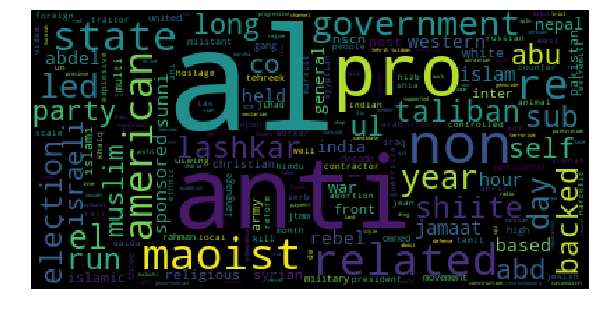

In [17]:

word_dist = nltk.FreqDist(words)
stopwords = nltk.corpus.stopwords.words('english')
words_except_stop_dist = nltk.FreqDist(w for w in words if w not in stopwords) 
wordcloud = WordCloud(stopwords=STOPWORDS,background_color='black').generate(" ".join(words_except_stop_dist))
plt.imshow(wordcloud)
fig=plt.gcf()
fig.set_size_inches(10,6)
plt.axis('off')
plt.show()

**Inference**: The wordcloud above shows the major occurences in the motive section of the dataset. The bigger the word, the more frequent it occurs. It can be seen that al(for al-kaeda), pro, anti are highly frequent words. It suggests that terrorist activities have some connection with the government.

## Data Preprocessing

The summary feature has summary description along with a datetime. We need to remove the datetime and only text to be present in the summary section.

In [18]:
all_year_df.summary.head(10)

0                                                  NaN
1                                                  NaN
2                                                  NaN
3                                                  NaN
4                                                  NaN
5    1/1/1970: Unknown African American assailants ...
6                                                  NaN
7    1/2/1970: Unknown perpetrators detonated explo...
8    1/2/1970: Karl Armstrong, a member of the New ...
9    1/3/1970: Karl Armstrong, a member of the New ...
Name: summary, dtype: object

In [19]:
#modified the summary with just text description
splitted_text_col = all_year_df.summary.str.split(':',n=1, expand=True)
all_year_df.summary = splitted_text_col[1]

In [20]:
all_year_df.isnull().sum()

eventid                    0
iyear                      0
imonth                     0
iday                       0
approxdate            173192
extended                   0
resolution            180181
country                    0
country_txt                0
region                     0
region_txt                 0
provstate                421
city                     434
latitude                5303
longitude               5304
specificity              753
vicinity                   0
location              126732
summary                66142
crit1                      0
crit2                      0
crit3                      0
doubtterr                  1
alternative           153259
alternative_txt       153259
multiple                   1
success                    1
suicide                    0
attacktype1                0
attacktype1_txt            0
                       ...  
propextent_txt        117937
propvalue             143425
propcomment           124309
ishostkid     

In [21]:
remove_columns = all_year_df.columns[all_year_df.isnull().mean() > 0.8]
all_year_df.drop(remove_columns, axis=1, inplace=True)

In [22]:
#combine all the sciting sources
all_year_df['scite_combined']= all_year_df['scite1'].fillna('').astype(str)+'+'+all_year_df['scite2'].fillna('').astype(str)+'+'+all_year_df['scite3'].fillna('').astype(str)
all_year_df['scite_combined'].replace(r'^\s*$', np.nan, regex=True, inplace=True)


In [23]:
#drop attributes that are duplicate of another
all_year_df.drop(['eventid','location','codes',
 'attacktype1',
 'country',
 'natlty1',
 'propextent','region',
 'scite1',
 'scite2',
 'scite3',
 'target1',                          
 'targsubtype1',
 'targtype1',
 'weapsubtype1',
 'weaptype1'], axis=1, inplace=True)

In [24]:
all_year_df.columns

Index(['iyear', 'imonth', 'iday', 'extended', 'country_txt', 'region_txt',
       'provstate', 'city', 'latitude', 'longitude', 'specificity', 'vicinity',
       'summary', 'crit1', 'crit2', 'crit3', 'doubtterr', 'multiple',
       'success', 'suicide', 'attacktype1_txt', 'targtype1_txt',
       'targsubtype1_txt', 'corp1', 'natlty1_txt', 'gname', 'motive',
       'guncertain1', 'individual', 'nperps', 'nperpcap', 'claimed',
       'weaptype1_txt', 'weapsubtype1_txt', 'weapdetail', 'nkill', 'nkillus',
       'nkillter', 'nwound', 'nwoundus', 'nwoundte', 'property',
       'propextent_txt', 'propvalue', 'propcomment', 'ishostkid', 'ransom',
       'dbsource', 'INT_LOG', 'INT_IDEO', 'INT_MISC', 'INT_ANY',
       'scite_combined'],
      dtype='object')

## Handling Missing values:
1. For Numerical categories -\begin{align}3\sigma  Rule\
\end{align} 
2. Categorical valariables - fill nan with -1
3. Text features - fill nan with 'UNKNOWN'

In [25]:
class MissingValueHandler:
    def __init__(self, dataframe):
        self.dataframe = dataframe
    
    def category_feature_handler(self, feature_name_list, unknown = False):
        if not unknown:
            for each_feature in feature_name_list:
                self.dataframe[each_feature].fillna(-1, inplace=True)
        else:
            for each_feature in feature_name_list:
                self.dataframe.loc[self.dataframe[each_feature] == -9, each_feature] = -1
                self.dataframe.loc[self.dataframe[each_feature] == -99, each_feature] = -1 
        return self.dataframe
    
    def text_feature_handler(self, feature_name_list):
        for each_feature in feature_name_list:
            self.dataframe[each_feature].fillna('UNKNOWN',inplace=True)
            
    def numerical_feature_handler(self, feature_name_list):
        for feat in feature_name_list:
            sigma = self.dataframe[feat].std(skipna=None)
            mean = self.dataframe[feat].mean(skipna=None)
            outlier = self.dataframe[np.abs(self.dataframe[feat]-mean) > (3*sigma)]
            
            filler = 0.0
            if outlier.empty:
                filler = mean
            else:
                filler = self.dataframe[feat].median(skipna=None)
            
            self.dataframe[feat] = self.dataframe[feat].fillna(filler)
            

In [26]:
category_features = ['extended','specificity','crit1','crit2','crit3','doubtterr','multiple',
                     'success','suicide', 'claimed', 'guncertain1']

category_with_unknowntype = ['property','ransom', 'ishostkid','vicinity','INT_LOG','INT_IDEO','INT_MISC','INT_ANY']

text_features = ['country_txt','region_txt','attacktype1_txt','targtype1_txt','weapdetail',
                'targsubtype1_txt','natlty1_txt','weaptype1_txt','weapsubtype1_txt','propextent_txt',
                'summary','provstate','motive','city','corp1','propcomment']

numerical_features = ['nkill', 'nkillus','nperps', 'nperpcap','propvalue',
                       'nkillter', 'nwound', 'nwoundus', 'nwoundte']

all_year_df.loc[all_year_df['scite_combined'] == '++', 'scite_combined'] = 'UNKNOWN'

#create an instance
obj = MissingValueHandler(all_year_df)

obj.category_feature_handler(feature_name_list = category_features)
obj.category_feature_handler(feature_name_list = category_with_unknowntype, unknown=True)
obj.numerical_feature_handler(feature_name_list = numerical_features)
obj.text_feature_handler(text_features)

In [27]:
#Change to categorical data type
less_than_three_categories = ['extended','crit1','crit2','crit3','doubtterr','multiple','success',
                              'suicide','individual','guncertain1', 'claimed', 'property', 'ransom', 
                              'ishostkid', 'vicinity','INT_LOG','INT_IDEO','INT_MISC','INT_ANY']

mapper_dict = {1:'YES', 0: 'NO', -1: 'UNKNOWN'}
for category in less_than_three_categories:
    all_year_df[category+'_txt'] = all_year_df[category].map(mapper_dict)
    all_year_df[category+'_txt'] = all_year_df[category+'_txt'].astype('category')

#now remove the older ones
all_year_df.drop(less_than_three_categories, axis=1, inplace=True)


In [28]:
#change the object datatype to category for category features
convert_to_categorytype = ['specificity','country_txt','region_txt','attacktype1_txt','targtype1_txt',
                            'targsubtype1_txt','extended_txt','natlty1_txt','weaptype1_txt','weapsubtype1_txt','propextent_txt','city','corp1']
for category in convert_to_categorytype:
    all_year_df[category] = all_year_df[category].astype('category')

In [29]:
all_year_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 182438 entries, 0 to 182437
Data columns (total 53 columns):
iyear               182438 non-null int64
imonth              182438 non-null int64
iday                182438 non-null int64
country_txt         182438 non-null category
region_txt          182438 non-null category
provstate           182438 non-null object
city                182438 non-null category
latitude            177135 non-null float64
longitude           177134 non-null float64
specificity         182438 non-null category
summary             182438 non-null object
attacktype1_txt     182438 non-null category
targtype1_txt       182438 non-null category
targsubtype1_txt    182438 non-null category
corp1               182438 non-null category
natlty1_txt         182438 non-null category
gname               182438 non-null object
motive              182438 non-null object
nperps              182438 non-null float64
nperpcap            182438 non-null float64
weaptype1_

## Modeling

### Objective: Prediction of Attack Group

Usually ensemble models like Random Forest classifier performs well with high dimensional multiclass problems. So we will start with this as a baseline model for our objective.

Note:Cross-validation is not necessary when using random forest, because multiple bagging in process of training random forest prevents over-fitting.

In [30]:
#let's look at our target labels
all_year_df.gname.value_counts()

Unknown                                                   82984
Taliban                                                    7478
Islamic State of Iraq and the Levant (ISIL)                5613
Shining Path (SL)                                          4589
Farabundo Marti National Liberation Front (FMLN)           3351
Al-Shabaab                                                 3288
New People's Army (NPA)                                    2772
Irish Republican Army (IRA)                                2758
Revolutionary Armed Forces of Colombia (FARC)              2494
Boko Haram                                                 2418
Kurdistan Workers' Party (PKK)                             2354
Basque Fatherland and Freedom (ETA)                        2031
Communist Party of India - Maoist (CPI-Maoist)             1878
Maoists                                                    1630
Liberation Tigers of Tamil Eelam (LTTE)                    1613
National Liberation Army of Colombia (EL

Note: Lot of attack groups that made a single attack. Thus we will remove groups which carried out less than 20 attacks. And also we only consider the known groups.

In [31]:
target_groups = all_year_df.gname.value_counts()
target_groups = target_groups[target_groups>19]
groups_list = target_groups.index[target_groups.index!='Unknown']
target_group_df = all_year_df[all_year_df['gname'].isin(groups_list)]

In [32]:
#romving text features
target_group_df.drop(['scite_combined','weapdetail','summary','provstate','latitude','longitude'
                      ,'motive','city','corp1','propcomment','dbsource'],axis=1, inplace=True)

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [33]:
#Standardization of the numerical columns
scaler = preprocessing.RobustScaler()
scale_attrs = ['propvalue','nperpcap', 'nperps','nkill', 'nkillus', 'nkillter', 
               'nwound', 'nwoundus', 'nwoundte']#numerical column

target_group_df[scale_attrs].describe().transpose()
target_group_df[scale_attrs] = scaler.fit_transform(target_group_df[scale_attrs])


/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/usr/local/lib/python3.5/dist-packages/pandas/core/indexing.py:477: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [34]:
#transform target labels into 0,1
le = preprocessing.LabelEncoder()
le.fit(target_group_df.gname)
# le.classes_
label_codes = le.transform(target_group_df.gname)


In [35]:
seed = 123

X = pd.get_dummies(target_group_df.drop(['gname'], axis=1), drop_first=True)
y = label_codes
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = seed, stratify = y)

###### Note:
The below gridsearchcv is used to find the best parameter value of all the combinations. It will take lot of computation time.

In [36]:
# from sklearn.model_selection import GridSearchCV

# # Create the parameter grid based on the results of random search 
# param_grid = {
#     'bootstrap': [True],
#     'max_features': [13, 50],
#     'min_samples_leaf': [3, 5, 10],
#     'min_samples_split': [8, 10, 12],
#     'n_estimators': [50, 75, 100, 125]
# }

# # Create a based model
# rf1 = RandomForestClassifier()

# # Instantiate the grid search model
# grid_search = GridSearchCV(estimator = rf1, param_grid = param_grid, 
#                           cv = 3, n_jobs = -1)
#grid_search.best_params_

In [37]:

start = time.time()
# Create the model
rf1 = RandomForestClassifier(criterion='gini',
                                 n_estimators=100,
                                 min_samples_split=10,
                                 min_samples_leaf=1,
                                 oob_score=True,
                                 random_state=seed,
                                 n_jobs=-1)
# Fit it to the training data
rf1.fit(X_train, y_train)
end = time.time()
print("Execution Seconds: {}".format((end - start)))

Execution Seconds: 130.4593722820282


In [38]:
# Get the modified column names with one hot encoding
column_names = list(X_train.columns.values)

# Create a descending sorted list of variables by feature importance
var_imp = sorted(zip(map(lambda x: x, rf1.feature_importances_), column_names), 
             reverse = True)

print("\nFeatures Ranking - Top 10:\n")
for feat in var_imp[0:10]:
    print(feat)


Features Ranking - Top 10:

(0.05649972794797085, 'iyear')
(0.028422353300643643, 'region_txt_South Asia')
(0.02294022569910387, 'INT_IDEO_txt_YES')
(0.019615389373197005, 'INT_ANY_txt_YES')
(0.019348035038876908, 'natlty1_txt_Iraq')
(0.019144049031592347, 'country_txt_Peru')
(0.017362208167192836, 'natlty1_txt_Peru')
(0.017304901373110842, 'country_txt_Iraq')
(0.017174725832999296, 'claimed_txt_UNKNOWN')
(0.01664798064273926, 'region_txt_Middle East & North Africa')


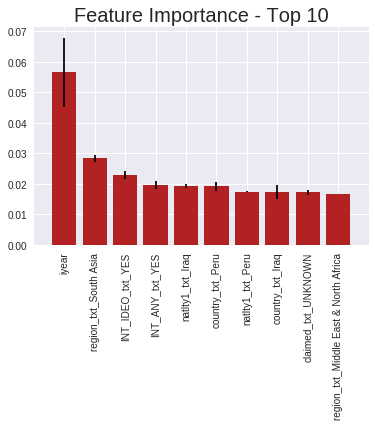

In [39]:
# Get the features, standard deviation and indices
importances = rf1.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf1.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Filter to the top 10
top_n = 10
top_n_importances = importances[indices][0:top_n]
top_n_std = std[0:top_n]
top_n_indices = indices[0:top_n]

# Create a list of x labels
x_labels = [column_names[t] for t in top_n_indices]

# Plot the results
plt.figure()
plt.title("Feature Importance - Top 10",  fontsize=20)
plt.bar(range(top_n), top_n_importances, color="firebrick", yerr = top_n_std, align="center")
plt.xticks(rotation=90)
plt.xticks(range(top_n), x_labels)
plt.xlim([-1, top_n])
plt.show()

**Inference**: Feature ranking helps us in identifying the contribution of features to our model. Year('iyear') tops the list, and it is common that most of the terrorist groups(or classes) activities can be attributed to the era of their period. Thus it makes sense why year tops the feature list

### Choosing the Performance metrics: Recal

### Recal - TP/(TP+FN)

##### Logic behind choosing the metric

Since this problem is to classify which group is responsible for the attack. It better to avoid **False Negatives**. That is I want to penalize the model which tells that the model classifies it attack for a wrong class than the correct class.

For eg: The 9/11 attack is caused due to al-Qaeda group(actual positive class). So I want penalize a machine learning model which says 9/11 attack is **not** due to al-Qaeda!

In [40]:
#avoid memory leaks by chunking your test set for prediction
split_test_list = np.vsplit(X_test,X_test.shape[0]/6)

In [41]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix

In [42]:
ans = []
for splitted_X_test in split_test_list:
# Predict labels on the test dataset
    pred_labels1 = rf1.predict(splitted_X_test)
    
    ans.extend(pred_labels1)

pred_labels1 = ans
# Calculate the accuracy of the model
acc_score1 = accuracy_score(y_test, pred_labels1)
print("\nAccuracy: {}".format(acc_score1))

# Calculate the precision of the model
prec_score1 = precision_score(y_test, pred_labels1, average='weighted')
print("\nPrecision: {}".format(prec_score1))

# Calculate the recall of the model
rcll_score1 = recall_score(y_test, pred_labels1, average='weighted')
print("\nRecall: {}".format(rcll_score1))

# Calculate the F1 of the model
f1_score1 = f1_score(y_test, pred_labels1, average='weighted')
print("\nF1: {}".format(f1_score1))


Accuracy: 0.8431860954278756

Precision: 0.8305226059707872

Recall: 0.8431860954278756

F1: 0.8207572340143373


/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



References:
1. [Handling Missing data](https://www.oreilly.com/learning/handling-missing-data)
2. [Hyperparameter tunning in Randomforest](https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74)
3. [How to avoid memory leaks](https://www.kaggle.com/c/datasciencebowl/discussion/12520)
4. [Sklearn random forest parameters](https://scikit-learn.org/stable/modules/ensemble.html#forest)
5. [National Consortium for the Study of Terrorism and Responses to Terrorism (START). (2018). Global Terrorism Database](https://www.start.umd.edu/gtd)